In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# only needed for tutorial, monkey patches visualization
sys.path.append('..')
import open3d_tutorial
# change to True if you want to interact with the visualization windows
open3d_tutorial.interactive = not "CI" in os.environ

# Distance Queries

The `RaycastingScene` class in Open3D provides a set of distance queries, which can be used to convert triangle meshes into implicit functions, query the distance to the surface or determine if a point is inside a mesh.

![Distance field computed from a mesh](images/distance_field_animation.gif)

In this tutorial we show how to generate these queries and produce pupular implicit representations from meshes as used in geometry processing and 3D machine learning.

## Converting a mesh to an implicit representation

**Initialization**

As the first step we initialize a `RaycastingScene` with a (closed) triangle mesh

In [2]:
# Load mesh and convert to open3d.t.geometry.TriangleMesh
mesh = open3d_tutorial.get_armadillo_mesh()
mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)

# Create a scene and add the triangle mesh
scene = o3d.t.geometry.RaycastingScene()
_ = scene.add_triangles(mesh)  # we do not need the geometry ID for mesh

**Computing distances and occupancy for a single point**

*RaycastingScene* directly provides functions to compute the unsigned and signed distance from a point to the mesh surface.
It also provides a function to compute the occupancy at a query point.

In [3]:
query_point = o3d.core.Tensor([[10, 10, 10]], dtype=o3d.core.Dtype.Float32)

# Compute distance of the query point from the surface
unsigned_distance = scene.compute_distance(query_point)
signed_distance = scene.compute_signed_distance(query_point)
occupancy = scene.compute_occupancy(query_point)

While the unsigned distance can always be computed, the signed distance and the occupancy are only valid if the mesh is watertight and the inside and outside are clearly defined. 
The signed distance is negative if the query point is inside the mesh.
The occupancy is either 0 for points outside the mesh and 1 for points inside the mesh.

In this example our mesh is watertight and we can see that the query point is inside the mesh because of the signed distance and the occupancy values.

In [4]:
print("unsigned distance", unsigned_distance.numpy())
print("signed_distance", signed_distance.numpy())
print("occupancy", occupancy.numpy())

unsigned distance [7.8694816]
signed_distance [-7.8694816]
occupancy [1.]


**Computing distances for multiple points and grids**

`RaycastingScene` allows multiple queries at once. 
For instance, we ca
n pass a [N,3] Tensor with N query points which can be used to randomly sample a volume for training implicit neural representations in machine learning.

In [5]:
min_bound = mesh.vertex['positions'].min(0).numpy()
max_bound = mesh.vertex['positions'].max(0).numpy()

N = 256
query_points = np.random.uniform(low=min_bound, high=max_bound,
                                 size=[N, 3]).astype(np.float32)

# Compute the signed distance for N random points
signed_distance = scene.compute_signed_distance(query_points)

`RaycastingScene` allows to organize query points with an arbitrary number of leading dimensions.
To query the signed distance for a grid we can do the following

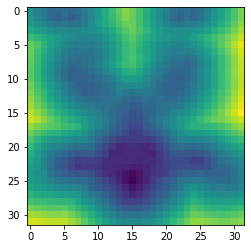

In [6]:
xyz_range = np.linspace(min_bound, max_bound, num=32)

# query_points is a [32,32,32,3] array ..
query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

# signed distance is a [32,32,32] array
signed_distance = scene.compute_signed_distance(query_points)

# We can visualize a slice of the distance field directly with matplotlib
plt.imshow(signed_distance.numpy()[:, :, 15])

The same procedure works for `RaycastingScene.compute_distance` and `RaycastingScene.compute_occupancy`, which can be used to generate the unsigned distance and occupancy fields.

## Computing distances with closest point queries

The distance functions are built on top of the `compute_closest_points()` function.
In this part we will reimplement the signed distance and show how to make use of the additional information returned by the `compute_closest_points()` function.

**Initialization**

We first initialize a `RaycastingScene` with two triangle meshes. 
Both meshes are watertight and we will place them such that there are no intersections between them.

In [7]:
cube = o3d.t.geometry.TriangleMesh.from_legacy(
    o3d.geometry.TriangleMesh.create_box().translate([-1.2, -1.2, 0]))
sphere = o3d.t.geometry.TriangleMesh.from_legacy(
    o3d.geometry.TriangleMesh.create_sphere(0.5).translate([0.7, 0.8, 0]))

scene = o3d.t.geometry.RaycastingScene()
# Add triangle meshes and remember ids
mesh_ids = {}
mesh_ids[scene.add_triangles(cube)] = 'cube'
mesh_ids[scene.add_triangles(sphere)] = 'sphere'

**Computing the closest point on the surface**

`RaycastingScene.compute_closest_points()` can compute the closest point on the surface with respect to a query point.

In [8]:
query_point = o3d.core.Tensor([[0, 0, 0]], dtype=o3d.core.Dtype.Float32)

# We compute the closest point on the surface for the point at position [0,0,0].
ans = scene.compute_closest_points(query_point)

# Compute_closest_points provides the point on the surface, the geometry id,
# and the primitive id.
# The dictionary keys are
#.    points
#.    geometry_ids
#.    primitive_ids
print('The closest point on the surface is', ans['points'].numpy())
print('The closest point is on the surface of the',
      mesh_ids[ans['geometry_ids'][0].item()])
print('The closest point belongs to triangle', ans['primitive_ids'][0].item())

The closest point on the surface is [[-0.2 -0.2  0. ]]
The closest point is on the surface of the cube
The closest point belongs to triangle 0


To compute whether the point is inside or outside we can cast a ray starting at the query point and count the number of intersections

In [9]:
rays = np.concatenate(
    [query_point.numpy(),
     np.ones(query_point.shape, dtype=np.float32)],
    axis=-1)
intersection_counts = scene.count_intersections(rays).numpy()
# A point is inside if the number of intersections with the scene is even
# This sssumes that inside and outside is we ll defined for the scene.
is_inside = intersection_counts % 2 == 1

We can combine this into one function to create a special signed distance function with returns additional information:

In [10]:
def compute_signed_distance_and_closest_goemetry(query_points: np.ndarray):
    closest_points = scene.compute_closest_points(query_points)
    distance = np.linalg.norm(query_points - closest_points['points'].numpy(),
                              axis=-1)
    rays = np.concatenate([query_points, np.ones_like(query_points)], axis=-1)
    intersection_counts = scene.count_intersections(rays).numpy()
    is_inside = intersection_counts % 2 == 1
    distance[is_inside] *= -1
    return distance, closest_points['geometry_ids'].numpy()

We can use the function to create a grid with the distance and geometry id information

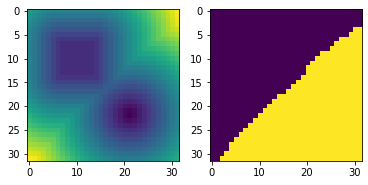

In [11]:
# compute range
xyz_range = np.linspace([-2, -2, -2], [2, 2, 2], num=32)
# query_points is a [32,32,32,3] array ..
query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

sdf, closest_geom = compute_signed_distance_and_closest_goemetry(query_points)

# We can visualize a slice of the grids directly with matplotlib
fig, axes = plt.subplots(1, 2)
axes[0].imshow(sdf[:, :, 16])
axes[1].imshow(closest_geom[:, :, 16])